In [131]:
import os
import polars as pl
import utils
import plotly.express as px
from plotly.subplots import make_subplots

import plotly.io as pio
pio.renderers.default = "png" # needed for px figures to render on nbviewer and github

os.chdir(os.getcwd())

In [132]:
ridership_df = pl.read_csv('data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals_20250203.csv')

ridership_df = ridership_df.rename(
    {
        'stationname': 'station_name',
        'daytype': 'day_type'
    }
)

In [133]:
ridership_df.head(10)

station_id,station_name,date,day_type,rides
i64,str,str,str,i64
41280,"""Jefferson Park""","""12/22/2017""","""W""",6104
41000,"""Cermak-Chinatown""","""12/18/2017""","""W""",3636
40280,"""Central-Lake""","""12/02/2017""","""A""",1270
40140,"""Dempster-Skokie""","""12/19/2017""","""W""",1759
40690,"""Dempster""","""12/03/2017""","""U""",499
41660,"""Lake/State""","""12/30/2017""","""A""",8615
40180,"""Oak Park-Forest Park""","""12/17/2017""","""U""",442
40250,"""Kedzie-Homan-Forest Park""","""12/02/2017""","""A""",1353
40120,"""35th/Archer""","""12/07/2017""","""W""",3353


In [134]:
# Generate int columns for year, month, and day from the date column
ridership_df = ridership_df.with_columns(
    pl.col('date').str.to_date('%m/%d/%Y')
)

ridership_df = ridership_df.with_columns(
    year=pl.col('date').dt.year(),
    month=pl.col('date').dt.month(),
    day=pl.col('date').dt.day()
)

In [135]:
# Filter to a restricted date range to limit the size of the data in memory
min_year = 2018
max_year = 2024

ridership_df = ridership_df.filter(
    pl.col('year').is_between(min_year, max_year)
)

ridership_df = ridership_df.sort(['station_id', 'year', 'month', 'day'])

In [136]:
ridership_df.head(10)

station_id,station_name,date,day_type,rides,year,month,day
i64,str,date,str,i64,i32,i8,i8
40010,"""Austin-Forest Park""",2018-01-01,"""U""",343,2018,1,1
40010,"""Austin-Forest Park""",2018-01-02,"""W""",1187,2018,1,2
40010,"""Austin-Forest Park""",2018-01-03,"""W""",1429,2018,1,3
40010,"""Austin-Forest Park""",2018-01-04,"""W""",1447,2018,1,4
40010,"""Austin-Forest Park""",2018-01-05,"""W""",1391,2018,1,5
40010,"""Austin-Forest Park""",2018-01-06,"""A""",532,2018,1,6
40010,"""Austin-Forest Park""",2018-01-07,"""U""",450,2018,1,7
40010,"""Austin-Forest Park""",2018-01-08,"""W""",1773,2018,1,8
40010,"""Austin-Forest Park""",2018-01-09,"""W""",1808,2018,1,9


In [137]:
# Check that station ID, year, month, and day uniquely identify rows in the dataset 
primary_key_columns = ["station_id", "year", "month", "day"]

assert ridership_df.unique(subset=primary_key_columns).height == ridership_df.height, "Station ID, year, month, and day are not the primary keys."

# Data Visualizations

## Yearly Rides

In [138]:
ridership_df_year_level = ridership_df.group_by(
    'year'
).agg(
    pl.col('rides').sum() / 1e6
).sort(
    'year'
)

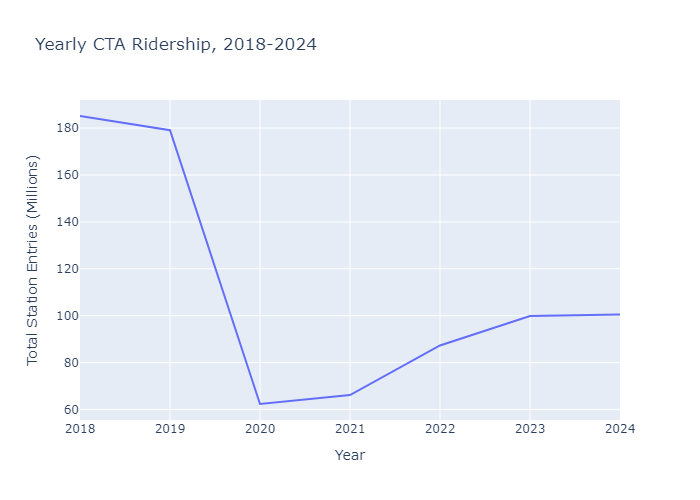

In [139]:
fig = px.line(
    ridership_df_year_level,
    x='year',
    y='rides',
    title='Yearly CTA Ridership, 2018-2024',
    labels={
        'year': 'Year',
        'rides': 'Total Station Entries (Millions)'
    }
)

fig.show()

## Ten busiest stations in 2018

In [140]:
busiest_stations_2018 = ridership_df.filter(
    pl.col('year') == 2018
).group_by(
    ['station_id', 'station_name', 'year']
).agg(
    total_ridership=pl.sum('rides')
).sort(
    'total_ridership',
    descending=True
).with_columns(
    total_ridership_millions = pl.col('total_ridership')/1e6
).head(10)

In [141]:
print(busiest_stations_2018)

shape: (10, 5)
┌────────────┬─────────────────────┬──────┬─────────────────┬──────────────────────────┐
│ station_id ┆ station_name        ┆ year ┆ total_ridership ┆ total_ridership_millions │
│ ---        ┆ ---                 ┆ ---  ┆ ---             ┆ ---                      │
│ i64        ┆ str                 ┆ i32  ┆ i64             ┆ f64                      │
╞════════════╪═════════════════════╪══════╪═════════════════╪══════════════════════════╡
│ 41660      ┆ Lake/State          ┆ 2018 ┆ 6604902         ┆ 6.604902                 │
│ 40380      ┆ Clark/Lake          ┆ 2018 ┆ 6048315         ┆ 6.048315                 │
│ 41450      ┆ Chicago/State       ┆ 2018 ┆ 4659252         ┆ 4.659252                 │
│ 40370      ┆ Washington/Dearborn ┆ 2018 ┆ 4031851         ┆ 4.031851                 │
│ 40890      ┆ O'Hare Airport      ┆ 2018 ┆ 3981492         ┆ 3.981492                 │
│ 40330      ┆ Grand/State         ┆ 2018 ┆ 3886450         ┆ 3.88645                  │
│ 4132

In [142]:
busiest_station_names_2018 = busiest_stations_2018.select('station_name').to_series()


busiest_stations_2024_from_2018 = ridership_df.filter(
    (pl.col('year') == 2024) & (pl.col('station_name').is_in(busiest_station_names_2018))
).group_by(
    ['station_id', 'station_name', 'year']
).agg(
    total_ridership=pl.sum('rides')
).sort(
    'total_ridership',
    descending=True
).with_columns(
    total_ridership_millions = pl.col('total_ridership')/1e6
)

In [143]:
busiest_stations_df_for_plot = pl.concat(
    [busiest_stations_2018, busiest_stations_2024_from_2018]
)

In [144]:
busiest_stations_df_for_plot.head(10)

station_id,station_name,year,total_ridership,total_ridership_millions
i64,str,i32,i64,f64
41660,"""Lake/State""",2018,6604902,6.604902
40380,"""Clark/Lake""",2018,6048315,6.048315
41450,"""Chicago/State""",2018,4659252,4.659252
40370,"""Washington/Dearborn""",2018,4031851,4.031851
40890,"""O'Hare Airport""",2018,3981492,3.981492
40330,"""Grand/State""",2018,3886450,3.88645
41320,"""Belmont-North Main""",2018,3813525,3.813525
40260,"""State/Lake""",2018,3779850,3.77985
41220,"""Fullerton""",2018,3751316,3.751316


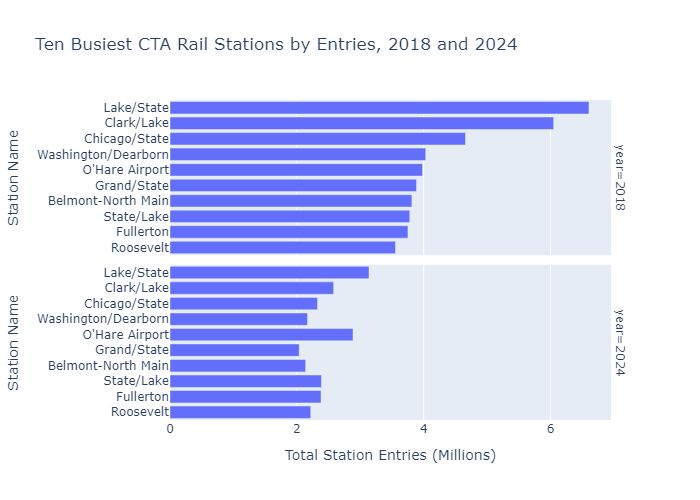

In [146]:
fig_2018_and_2024 = px.bar(
    busiest_stations_df_for_plot.sort('total_ridership_millions', descending=False),
    x='total_ridership_millions',
    y='station_name',
    orientation='h',
    facet_row='year',
    title='Ten Busiest CTA Rail Stations by Entries, 2018 and 2024',
    labels={
        'total_ridership_millions': 'Total Station Entries (Millions)',
        'station_name': 'Station Name'
    },
    category_orders={'year': [2018, 2024]}
)


fig_2018_and_2024.show()